# Metric learning for image similarity search

Metric learning aims to train models that can embed inputs into a high-dimensional space such that "similar" inputs, as defined by the training scheme, are located close to each other. These models once trained can produce embeddings for downstream systems where such similarity is useful; examples include as a ranking signal for search or as a form of pretrained embedding model for another supervised problem.

For a more detailed overview of metric learning see:

* [What is metric learning?](http://contrib.scikit-learn.org/metric-learn/introduction.html)
* [Using crossentropy for metric learning tutorial](https://www.youtube.com/watch?v=Jb4Ewl5RzkI)

# Dataset

For this example we will be working with the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

First we read the entire dataset into `X=(N, 32, 32, 3)` and `y=(N,)` tensors for the training and test splits.

In [1]:
pip install pretty-confusion-matrix

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

In [3]:
from datasets import load_dataset, load_metric
from transformers import (
    AutoModel, AutoFeatureExtractor, Trainer, TrainingArguments, set_seed
)

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    Resize,
    ToTensor,
)

import numpy as np
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report,  plot_confusion_matrix

from pretty_confusion_matrix import pp_matrix_from_data

In [4]:
DEVICE = "cuda"
SEED = 42

Reusing dataset cifar10 (/home/atsvigun/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


  0%|          | 0/2 [00:00<?, ?it/s]

Label: airplane


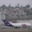

In [5]:
dataset = load_dataset("cifar10")

labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
    
instance = dataset["train"][0]
print("Label:", id2label[instance["label"]])
instance["img"]

In [6]:
set_seed(SEED)

model_checkpoint = "microsoft/resnet-18"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
    
model = AutoModel.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
).to(DEVICE)

Some weights of the model checkpoint at microsoft/resnet-18 were not used when initializing ResNetModel: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    if "img" in example_batch:
        example_batch["pixel_values"] = [
            transforms(image.convert("RGB")) for image in example_batch["img"]
        ]
    return example_batch

In [8]:
# split up training into training + validation
split = dataset["train"].train_test_split(
    test_size=0.99, seed=SEED, stratify_by_column="label"
)
train_query_split = split["train"].train_test_split(
    test_size=0.2, seed=SEED, stratify_by_column="label"
)
query_ds = train_query_split['test'].sort("label")
train_ds = train_query_split['train'].sort("label")

train_ds.set_transform(preprocess)
query_ds.set_transform(preprocess)
train_ds

Loading cached split indices for dataset at /home/atsvigun/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-e4e5019226156159.arrow and /home/atsvigun/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-5f01ff9b6b62eb48.arrow
Loading cached split indices for dataset at /home/atsvigun/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-83712190bb49848b.arrow and /home/atsvigun/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-8cc897b98cbc74d6.arrow
Loading cached sorted indices for dataset at /home/atsvigun/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-ce2f631e782742ea.arrow
Loading cached sorted indices for dataset at /hom

Dataset({
    features: ['img', 'label'],
    num_rows: 400
})

In [9]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [10]:
train_dataloader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=100,
    shuffle=False,
    pin_memory=True,
    collate_fn=collate_fn
)

query_dataloader = torch.utils.data.DataLoader(
    query_ds,
    batch_size=100,
    shuffle=False,
    pin_memory=True,
    collate_fn=collate_fn
)

In [11]:
n_data = len(train_ds)
n_query = len(query_ds)
emb_size = 512

In [12]:
def get_embeddings(dataloader, model):
    step = 100
    start = 0
    end = start + step
    
    embeddings_placeholder = torch.empty(
        len(dataloader.dataset), emb_size, device=DEVICE
    )
    labels_placeholder = torch.empty(
        len(dataloader.dataset), dtype=torch.int8, device=DEVICE
    )
    with torch.no_grad():
        for batch in tqdm(dataloader):
            embeddings = model(batch["pixel_values"].cuda())
            embeddings = embeddings.pooler_output[:, :, 0, 0]
            embeddings_placeholder[start:end].copy_(embeddings)
            labels_placeholder[start:end].copy_(batch["labels"].int())
            start = end
            end = end + step
    return embeddings_placeholder, labels_placeholder

In [13]:
query_embeddings, query_labels = get_embeddings(query_dataloader, model)

100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


In [14]:
train_embeddings, train_labels = get_embeddings(train_dataloader, model)

100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


In [15]:
batch_size = 10
num_batches = n_query // 10 if n_query % 10 == 0 else n_query // 10 + 1
most_similar_labels = torch.empty(
    n_query, dtype=torch.int8, device=DEVICE
)
for i in tqdm(range(num_batches)):
    batch = query_embeddings[i * batch_size : (i + 1) * batch_size]
    products = batch @ train_embeddings.T
    most_similar = products.argmax(1)
    
    batch_labels = query_labels[i * batch_size : (i + 1) * batch_size]
    most_similar_labels[i * batch_size : (i + 1) * batch_size].copy_(
        train_labels[most_similar]
    )

100%|██████████| 10/10 [00:00<00:00, 2575.40it/s]


In [16]:
acc_score = (query_labels == most_similar_labels).float().mean()
acc_score

tensor(0.3800, device='cuda:0')

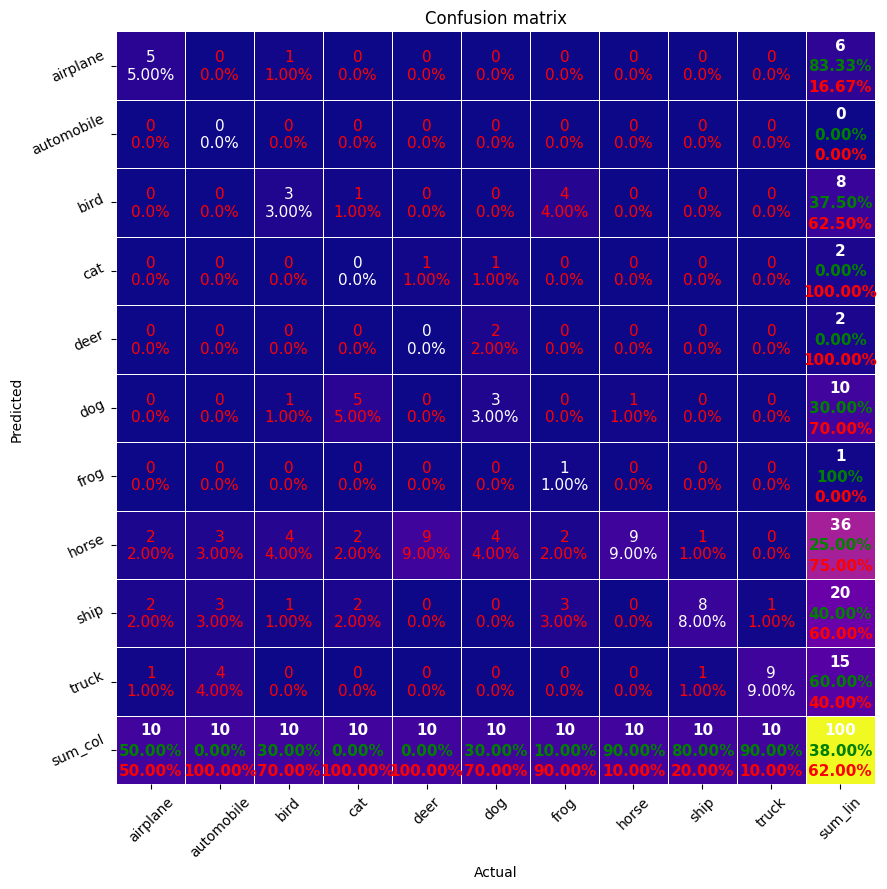

In [17]:
pp_matrix_from_data(
    query_labels.cpu().numpy(), most_similar_labels.cpu().numpy(), cmap="plasma",
    columns=label2id.keys()
)

### Triplet Loss

Triplet loss was originally proposed in the FaceNet (Schroff et al. 2015) paper and was used to learn face recognition of the same person at different poses and angles.

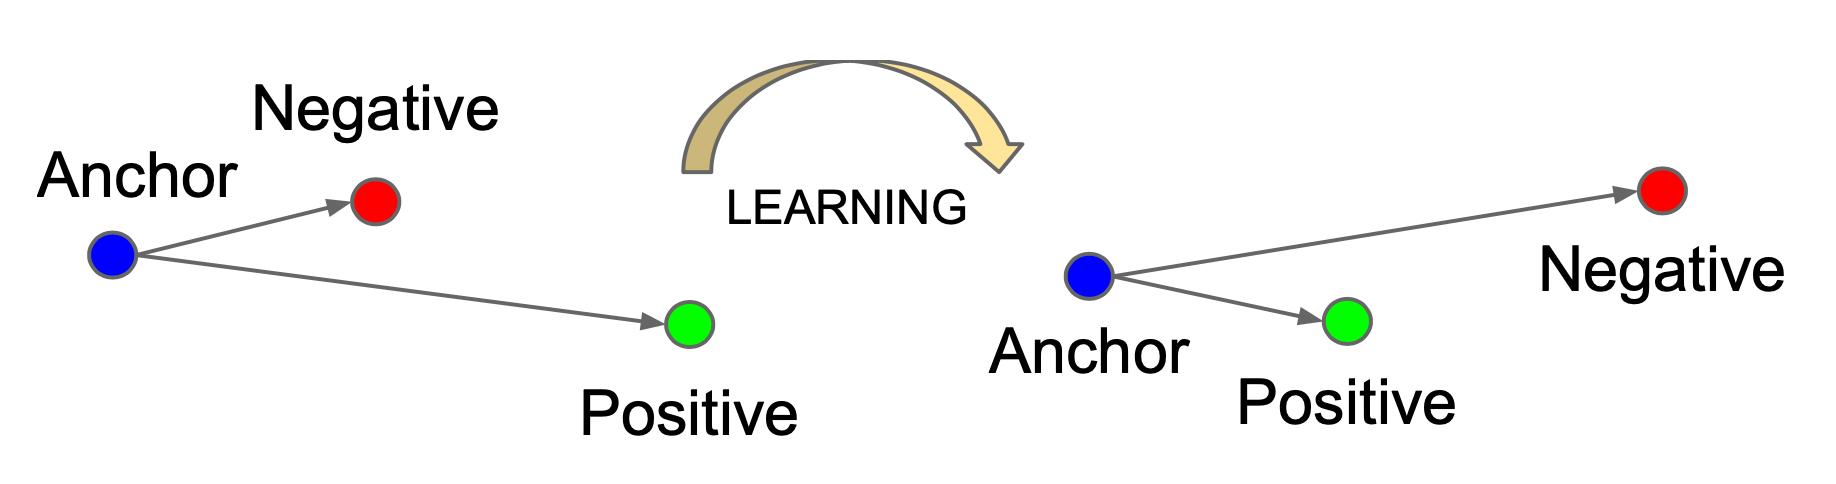

Given one anchor input $x$, we select one positive sample $x^+$ and one negative $x^-$, meaning that $x^+$ and $x$ belong to the same class and $x^-$ is sampled from another different class. Triplet loss learns to minimize the distance between the anchor $x$ and positive $x^+$ and maximize the distance between the anchor $x$ and negative $x^-$ at the same time with the following equation:

$\mathbb{L}_{triplet}(x, x^+, x^-) = \sum\limits_{x \in \mathbb{X}}\max(0, ||f(x) - f(x^+)||_2^2 - ||f(x) - f(x^-)||_2^2 + \epsilon$),

where the margin parameter $\epsilon$ is configured as the minimum offset between distances of similar vs dissimilar pairs.

It is crucial to select challenging $x^-$ to truly improve the model.

In [18]:
n_train_img_per_class = n_data // 10
n_train_img_per_class

40

In [19]:
class MLTrainer(Trainer):
    @staticmethod
    def compute_dist(x, y):
        diff = x - y
        return torch.einsum("bn,bn->b", diff, diff)
        
    def compute_loss(self, model, inputs, return_outputs=False):
        y_true = inputs.get(self.label_names[0])
        x = inputs.get("pixel_values")
        negatives = torch.empty(*x.shape, device=x.device)
        positives = torch.empty(*x.shape, device=x.device)
        for i, label in enumerate(y_true):
            # Create triples
            negative_id_to_select_from = list(range(n_train_img_per_class * label)) + \
                list(range(n_train_img_per_class * (label + 1), n_data))
            positive_id_to_select_from = range(
                n_train_img_per_class * label, n_train_img_per_class * (label + 1)
            )
            neg = self.train_dataset[
                int(np.random.choice(negative_id_to_select_from, 1)[0])
            ]
            negatives.copy_(torch.Tensor(neg["pixel_values"])).to(x.device)
            pos = self.train_dataset[
                int(np.random.choice(positive_id_to_select_from, 1)[0])
            ]
            positives.copy_(torch.Tensor(pos["pixel_values"])).to(x.device)
            
            assert (pos["label"] == label) and (neg["label"] != label)
        
        # forward pass
        anchor_embs = model(x).pooler_output[:, :, 0, 0]
        with torch.no_grad():
            pos_embs = model(positives).pooler_output[:, :, 0, 0]
            neg_embs = model(negatives).pooler_output[:, :, 0, 0]
        pos_dist = self.compute_dist(anchor_embs, pos_embs)
        neg_dist = self.compute_dist(anchor_embs, neg_embs)
        
        loss = torch.max(
            pos_dist - neg_dist + 1.,
            torch.zeros(len(pos_embs)).to(DEVICE)
        ).mean()
        
        if not return_outputs:
            self.train_data = None
            return loss
        
        # Eval part
        if getattr(self, "train_data", None) is None:
            dataloader = torch.utils.data.DataLoader(
                self.train_dataset,
                batch_size=100,
                shuffle=False,
                pin_memory=True,
                collate_fn=collate_fn
            )
            with torch.no_grad():
                train_embeddings, train_labels = get_embeddings(train_dataloader, model)
            self.train_data = {
                "embs": train_embeddings,
                "labels": train_labels
            }
        with torch.no_grad():
            products = anchor_embs @ self.train_data["embs"].T
            most_similar = torch.Tensor(
                self.train_dataset.select(products.argmax(1))["label"]
            )
            
        return (loss, {"y_preds": most_similar}) if return_outputs else loss

In [20]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-cifar",
    remove_unused_columns=False,
    evaluation_strategy = "steps",
    save_strategy = "steps",
    learning_rate=2e-6,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=16,
    max_steps=30,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    overwrite_output_dir=True,
    label_names=["labels"],
    report_to="none",
)

In [21]:
accuracy = load_metric("accuracy")
f1_score = load_metric("f1")

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    data = accuracy.compute(
        predictions=eval_pred.predictions, references=eval_pred.label_ids
    )
    data.update(f1_score.compute(
        predictions=eval_pred.predictions,
        references=eval_pred.label_ids,
        average="weighted"
    ))
    return data

In [22]:
model = AutoModel.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
).to(DEVICE)

Some weights of the model checkpoint at microsoft/resnet-18 were not used when initializing ResNetModel: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
trainer = MLTrainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=query_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

max_steps is given, it will override any value given in num_train_epochs


In [24]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 100
  Batch size = 16
100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


{'eval_loss': 42.985931396484375,
 'eval_accuracy': 0.38,
 'eval_f1': 0.30847891963109353,
 'eval_runtime': 1.7862,
 'eval_samples_per_second': 55.984,
 'eval_steps_per_second': 3.919}

In [25]:
train_results = trainer.train()

/home/atsvigun/anaconda3/envs/al/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 400
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss,Validation Loss,Accuracy,F1
10,1.491400,11.485217,0.280000,0.265785
20,1.369000,37.087257,0.320000,0.311575
30,1.598200,52.523941,0.330000,0.309704


***** Running Evaluation *****
  Num examples = 100
  Batch size = 16
100%|██████████| 4/4 [00:00<00:00,  5.63it/s]
***** Running Evaluation *****
  Num examples = 100
  Batch size = 16
100%|██████████| 4/4 [00:00<00:00,  5.94it/s]
***** Running Evaluation *****
  Num examples = 100
  Batch size = 16
100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Training completed. Do not forget to share your model on huggingface.co/models =)


